In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class DataPreparation:
    def __init__(self, num_objects=None, all_columns=True, columns_to_keep=None):
        self.dataset = None
        self.num_objects = num_objects
        self.all_columns = all_columns
        self.Wolumns_to_keep = columns_to_keep
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None


    def get_data(self):
        self.dataset = pd.read_csv('booking.csv')

        if not self.all_columns and self.Wolumns_to_keep:
            self.dataset = self.dataset[self.Wolumns_to_keep]

        self.dataset['booking status'] = self.dataset['booking status'].replace({'Canceled': -1, 'Not_Canceled': 1})

        if self.num_objects:
            self.dataset = self.dataset.head(self.num_objects)

        return self.dataset

    def scalars(self):
        standard_scaler = StandardScaler()
        robust_scaler = RobustScaler()

        transformations = {
            'average price': standard_scaler,
            'number of adults': standard_scaler,
            'lead time': np.log1p,
            'P-not-C': np.log1p,
            'number of week nights': np.log1p,
            'special requests': np.log1p,
            'number of children': robust_scaler,
            'number of weekend nights': robust_scaler,
            'P-C': robust_scaler
        }

        for column, transformer in transformations.items():
            if column in self.dataset.columns:  
                if callable(transformer): 
                    self.dataset[column] = transformer(self.dataset[column])
                else:  
                    self.dataset[column] = transformer.fit_transform(self.dataset[[column]])


    def split_data(self):
        x_train, x_test, y_train, y_test = train_test_split(
            self.dataset.drop(['booking status'], axis=1),
            self.dataset['booking status'],
            test_size=0.25,
            random_state=2,
            shuffle=False
        )

        duplicates_train = x_train.duplicated(keep='first')
        x_train = x_train[~duplicates_train].reset_index(drop=True)
        y_train = y_train[~duplicates_train].reset_index(drop=True)

        duplicates_test = x_test.duplicated(keep='first')
        x_test = x_test[~duplicates_test].reset_index(drop=True)
        y_test = y_test[~duplicates_test].reset_index(drop=True)

        self.x_train = x_train.iloc[:1000].reset_index(drop=True)
        self.y_train = y_train.iloc[:1000].reset_index(drop=True)
        self.x_test = x_test.iloc[:1000].reset_index(drop=True)
        self.y_test = y_test.iloc[:1000].reset_index(drop=True)

        return self.x_train, self.x_test, self.y_train, self.y_test
    
    def from_Wateforial_to_numeric(self):
        self.dataset['booking status'] = self.dataset['booking status'].replace({-1 : 0, 'Not_Canceled' : 1})
        self.dataset['type of meal'] = self.dataset['type of meal'].apply(lambda x: 0 if x == 'Not Selected' else int(x.split(' ')[-1]))
        self.dataset['room type'] = self.dataset['room type'].apply(lambda x: int(x.split(' ')[-1]))
        self.dataset['market segment type'] = self.dataset['market segment type'].replace({'Offline' : 0, 'Online' : 1, 'Aviation' : 2, 'Complementary' : 3, 'Corporate' : 4})
    
    def to_array(self, x_data, y_data):
        x_array = x_data.to_numpy()
        y_array = y_data.to_numpy()
        return x_array, y_array

    def to_dataframe(self, x_array, y_array, feature_columns, target_column):
        x_data = pd.DataFrame(x_array, columns=feature_columns)
        y_data = pd.DataFrame(y_array, columns=[target_column])
        return x_data, y_data
    
    def return_dataset(self):
        return self.dataset

In [3]:
num_obj = 5000
columns_to_keep = ['lead time', 'number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'average price', 'special requests', 'booking status']
data_linear = DataPreparation(num_objects=num_obj, all_columns=False, columns_to_keep=columns_to_keep)
data_linear.get_data()
data_linear.scalars()
x_train, x_test, y_train, y_test = data_linear.split_data()
dataset = data_linear.return_dataset()
print(x_train.head())

   lead time  number of adults  number of children  number of weekend nights  \
0   5.416100         -1.650825                 1.0                       0.5   
1   1.791759         -1.650825                 0.0                       0.0   
2   0.693147          0.281773                 1.0                       0.0   
3   5.356586         -1.650825                 0.0                      -0.5   
4   3.891820         -1.650825                 0.0                       0.0   

   number of week nights  average price  special requests  
0               1.791759      -0.433062          0.000000  
1               1.386294       0.105670          0.693147  
2               1.386294      -1.528985          0.000000  
3               1.098612      -0.086981          0.693147  
4               1.098612      -0.750303          0.000000  


/tmp/ipykernel_8824/1375659565.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.dataset['booking status'] = self.dataset['booking status'].replace({'Canceled': -1, 'Not_Canceled': 1})


In [4]:
def soft_max(z):
    z_stable = z - np.max(z)   
    exp = np.exp(z_stable)
    sum_exp = np.sum(exp)
    probs = exp / sum_exp
    return probs

def cross_entr(y_true, probs):
    eps = 1e-8
    loss = -np.sum(y_true * np.log(probs + eps)) # dirty trick
    return loss

def soft_argmax_crossentropy(y_true, z):
    p = soft_max(z)
    loss = cross_entr(y_true, p)
    grad = p - y_true
    return loss, grad

In [5]:
class AbstractLayes:
    def __init__(self, in_dim, out_dim, activation='identity', gamma=1.0, is_last=False, use_adam=True, beta1=0.9, beta2=0.999):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.activation_type = activation
        self.is_last = is_last
        self.use_adam = use_adam
        self.beta1 = beta1
        self.beta2 = beta2
        self.gamma = gamma

        self.setup()

        if self.use_adam:
            self.m_W = np.zeros_like(self.W)
            self.m_b = np.zeros_like(self.b)
            self.v_W = np.zeros_like(self.W)
            self.v_b = np.zeros_like(self.b)
            self.t = 0

        self.input = None
        self.apply_lay = None
        self.apply_fun = None

    def setup(self):
        if self.activation_type == 'relu':
            std = np.sqrt(2.0 / self.in_dim)
            self.W = np.random.randn(self.in_dim, self.out_dim) * std
        elif self.activation_type == 'tanh':
            border = np.sqrt(6.0 / (self.in_dim + self.out_dim))
            self.W = np.random.uniform(-border, border, size=(self.in_dim, self.out_dim))
        else:
            self.W = 0.01 * np.random.randn(self.in_dim, self.out_dim)
        self.b = np.zeros(self.out_dim)

    def activation(self, z):
        if self.activation_type == 'identity':
            return z
        elif self.activation_type == 'relu':
            return np.maximum(0, z)
        elif self.activation_type == 'tanh':
            return np.tanh(z)
        else:
            raise ValueError(self.activation_type)

    def activation_derivative(self, z):
        if self.activation_type == 'identity':
            return np.ones_like(z)
        elif self.activation_type == 'relu':
            return (z > 0).astype(float)
        elif self.activation_type == 'tanh':
            return 1 - np.tanh(z)**2

    def update_parameters(self, lr=0.01, l2_lambda=0.0):
        if self.use_adam:
            self.t += 1
            beta1 = self.beta1
            beta2 = self.beta2
            eps = 1e-8

            self.dL_dW += l2_lambda * self.W

            self.m_W = beta1 * self.m_W + (1 - beta1) * self.dL_dW
            self.m_b = beta1 * self.m_b + (1 - beta1) * self.dL_db

            self.v_W = beta2 * self.v_W + (1 - beta2) * (self.dL_dW**2)
            self.v_b = beta2 * self.v_b + (1 - beta2) * (self.dL_db**2)

            m_W_hat = self.m_W / (1 - beta1**self.t)
            v_W_hat = self.v_W / (1 - beta2**self.t)

            m_b_hat = self.m_b / (1 - beta1**self.t)
            v_b_hat = self.v_b / (1 - beta2**self.t)

            self.W -= lr * m_W_hat / (np.sqrt(v_W_hat) + eps)
            self.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + eps)
        else:
            self.dL_dW += l2_lambda * self.W
            self.W -= lr * self.dL_dW
            self.b -= lr * self.dL_db
            
    def get_params_for_l2(self):
        return [self.W]

In [6]:
class LinearLayer(AbstractLayes):
    def __init__(self, in_dim, out_dim, activation='identity', is_last=False, use_adam=True, beta1=0.9, beta2=0.999, gamma=1.0):
        super().__init__(in_dim, out_dim, activation=activation, gamma=gamma, is_last=is_last, use_adam=use_adam, beta1=beta1, beta2=beta2)

    def forward(self, x):
        if not isinstance(x, np.ndarray): x = np.array(x)
        self.input = x
        self.apply_lay = self.input @ self.W + self.b
        self.apply_fun = self.apply_lay if self.is_last else self.activation(self.apply_lay)
        return self.apply_fun

    def backward(self, dL_dy):
        if not self.is_last: dL_dz = dL_dy * self.activation_derivative(self.apply_lay)
        else: dL_dz = dL_dy

        self.dL_dW = np.outer(self.input, dL_dz)
        self.dL_db = dL_dz

        dL_dx = self.W @ dL_dz
        return dL_dx

In [7]:
class RBFKernelLayer(AbstractLayes):
    def __init__(self, in_dim, out_dim, activation='identity', gamma=1.0, is_last=False, use_adam=True, beta1=0.9, beta2=0.999):
        super().__init__(in_dim, out_dim, activation=activation, gamma=gamma, is_last=is_last, use_adam=use_adam, beta1=beta1, beta2=beta2)

    def forward(self, x):
        if not isinstance(x, np.ndarray): x = np.array(x)
        self.input = x
        diff = x.reshape(-1, 1) - self.W
        sq_dist = np.sum(diff**2, axis=0)
        out = np.exp(-self.gamma * sq_dist) + self.b
        self.output = out
        return out

    def backward(self, dL_dy):
        diff = self.input.reshape(-1, 1) - self.W 
        out_wo_b = np.exp(-self.gamma * np.sum(diff**2, axis=0))
        dL_dy = dL_dy.reshape(1, -1)
        out_wo_b = out_wo_b.reshape(1, -1)
        factor = dL_dy * out_wo_b * (-2.0 * self.gamma)
        self.dL_dW = factor * diff
        self.dL_db = dL_dy.reshape(-1)
        factor2 = dL_dy * out_wo_b * (2.0 * self.gamma)
        dL_dx = np.sum(factor2 * diff, axis=1)
        return dL_dx

In [8]:
class Model:
    def __init__(self, layers, rate=0.01, name=None, dropout_rate=0.0, l2_lambda=0, use_adam=True, beta1=0.9, beta2=0.999):
        self.layers = layers
        self.rate = rate
        self.loss = 0
        self.name = name
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.use_adam = use_adam
        self.beta1 = beta1
        self.beta2 = beta2

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad  
    
    def update(self):
        for layer in self.layers:
            layer.update_parameters(lr=self.rate, l2_lambda=self.l2_lambda)
    
    def predict(self, x):
        values = self.forward(x)
        probs = soft_max(values)
        pred_class = np.argmax(probs)
        return pred_class
    
    def get_loss(self):
        return self.loss
    
    def __str__(self):
        ans = ''
        ans += f"Имя модели : {self.name}\n"
        ans += f"Слои : {len(self.layers)}\n"
        ans += f"Loss : {self.loss}\n"
        return ans

    def fit_model(self, epoch, x, y):
        history = []
        cur_len = len(x)
        
        for _ in range(epoch):
            loss_cur_epoch = 0.0
            indices = np.random.permutation(cur_len)
            
            for curInd in indices:
                x_i = x.iloc[curInd].values
                y_i = y.iloc[curInd]
                
                logits = self.forward(x_i)
                loss, grad = soft_argmax_crossentropy(y_i, logits)
                
                l2_loss = 0.0
                for layer in self.layers:
                    for param in layer.get_params_for_l2():
                        l2_loss += np.sum(param**2)
                
                loss_with_reg = loss + 0.5 * self.l2_lambda * l2_loss 
                loss_cur_epoch += loss_with_reg
                self.backward(grad)
                self.update()
                
            avg_epoch_loss = loss_cur_epoch / cur_len
            history.append(avg_epoch_loss)
        
        self.loss = history[-1]
        return history

    def accuracy(self, X, Y):
        correct = 0
        total = len(X)
        for i in range(total):
            x_i = X.iloc[i]
            y_true = Y.iloc[i]
            y_pred = self.predict(x_i)
            if y_pred == y_true:
                correct += 1
        return correct / total

In [9]:
class selection:
    def __init__(self, models):
        self.models = models
        self.history_model = {}
    
    def train_all_models(self, x, y, epoch):
        for idx, model in enumerate(self.models):
            model_history = model.fit_model(epoch, x, y)
            self.history_model[idx] = model_history
                   
    def chose(self): # !!! for every model
        best_model = None
        best_loss = float('inf')
        for model in self.models:
            cur_loss = model.get_loss()
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_model = model
        return best_model
    
    def plot_graph(self):
        plt.figure(figsize=(8,5))
        for idx, history in self.history_model.items():
            plt.plot(history, label=f"{self.models[idx].name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
            
    def get_all_acc(self, x, y):
        for idx, model in enumerate(self.models):
            acc = model.accuracy(x, y)
            print(f"{model.name} accuracy: {acc * 100:.2f}%")


Лучшая модель:
Имя модели : RBF+Linear
Слои : 2
Loss : 0.6155146785772242



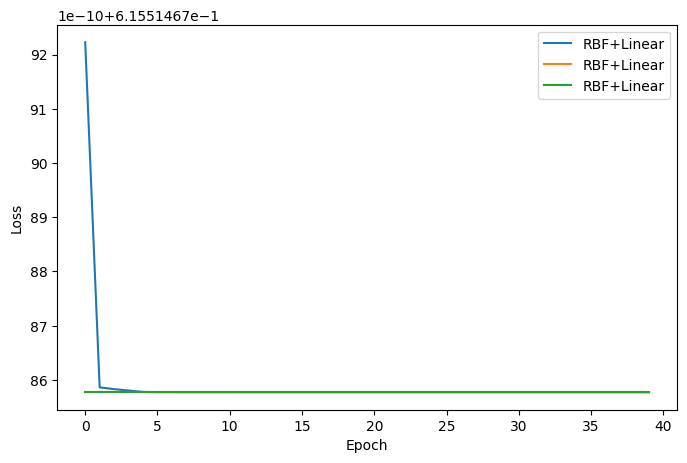

RBF+Linear accuracy: 0.00%
RBF+Linear accuracy: 0.00%
RBF+Linear accuracy: 0.00%


In [13]:
d = x_train.shape[1]   
classes = 2

model1 = Model(
    layers=[LinearLayer(in_dim=d, out_dim=classes, activation='identity', is_last=True)],
    rate=0.01,
    name="Model 1"
)

model2 = Model(
    layers=[
        LinearLayer(in_dim=d, out_dim=10, activation='relu', is_last=False),
        LinearLayer(in_dim=10, out_dim=25, activation='idereluntity', is_last=False),
        LinearLayer(in_dim=25, out_dim=classes, activation='tanh', is_last=True)
    ],
    rate=0.01,
    name="Model 2"
)

model3 = Model(
    layers=[
        LinearLayer(in_dim=d, out_dim=15, activation='tanh', is_last=False),
        LinearLayer(in_dim=15, out_dim=15, activation='relu', is_last=False),
        LinearLayer(in_dim=15, out_dim=15, activation='relu', is_last=False),
        LinearLayer(in_dim=15, out_dim=classes, activation='identity', is_last=True)
    ],
    rate=0.01,
    name="Model 3"
)

model_rbf = Model(
    layers=[
        RBFKernelLayer(in_dim=d, out_dim=30, gamma=1.0, is_last=False, use_adam=False),
        RBFKernelLayer(in_dim=30, out_dim=classes, gamma=0.5, is_last=True, use_adam=True),
    ],
    rate=0.001,
    name="RBF+Linear"
)


models = [model_rbf, model_rbf, model_rbf]

sel = selection(models)

epochs = 40
sel.train_all_models(x_train, y_train, epochs)
best_model = sel.chose()
print("Лучшая модель:")
print(best_model)
sel.plot_graph()
sel.get_all_acc(x_test, y_test)
